In [145]:
import mysql.connector as connection
import pandas as pd
import seaborn as sns
import numpy as np

In [109]:
import matplotlib.pyplot as plt

In [110]:
mydb=connection.connect(host="localhost",user="root",passwd="1234", database="ecommerce",use_pure=True)
cursor = mydb.cursor() #creating cursor to execute query

In [105]:
#1. List all unique cities where customers are located.
query = """ select distinct customer_city from customers; """

cursor.execute(query)

data = cursor.fetchall()  #fetchall(): Fetches all rows from the executed query.
df=pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


In [94]:
#2 Count the number of orders placed in 2017.
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cursor.execute(query)

data = cursor.fetchall()  #fetchall(): Fetches all rows from the executed query.
df=pd.DataFrame(data)
df

,0
0,225505


In [95]:
# 3. Find the total sales per category.
query = """ select products.product_category category,
round(sum(payments.payment_value),2) sales
from products 
join order_items
on products.product_id=order_items.product_id  #since there was no direct join from product to
join payments
on payments.order_id = order_items.order_id
group by category; """

cursor.execute(query)

data = cursor.fetchall()  #fetchall(): Fetches all rows from the executed query.
df=pd.DataFrame(data)
df

,0,1
0,perfumery,13730094.90
1,babies,14593358.06
2,automotive,23016926.55
3,Watches present,38609565.17
4,electronics,7016707.07
...,...,...
69,cds music dvds,32384.61
70,La Cuisine,78665.31
71,Fashion Children's Clothing,21213.09
72,PC Gamer,58709.61


In [112]:
#4 Calculate the percentage of orders that were paid in installments.
a = """
select count(payment_installments)
from payments
where payment_installments > 1
"""
cursor.execute(a)

data_a = cursor.fetchone()

data_a=int(data_a[0])
data_a

154014

In [113]:
b="""select count(payment_installments)
from payments
"""
cursor.execute(b)

data_b = cursor.fetchone()

data_b=int(data_b[0])
data_b

311658

In [114]:
print('percentage =',(data_a/data_b)*100)

percentage = 49.41763086460158


In [121]:
# or by  direct methord
query = """
select (sum(case when payment_installments >1 then 1 else 0 end))/count(*)*100
from payments """

cursor.execute(query)
# Fetch the result
data = cursor.fetchone()

data

(Decimal('49.4176'),)

In [123]:
#5. Count the number of customers from each state.

query = """
select customer_state, count(customer_unique_id)
from customers
group by customer_state
"""

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()

df = pd.DataFrame(data,columns=['state','count'])
df.head()

,state,count
0,SP,208730
1,SC,18185
2,MG,58175
3,PR,25225
4,RJ,64260


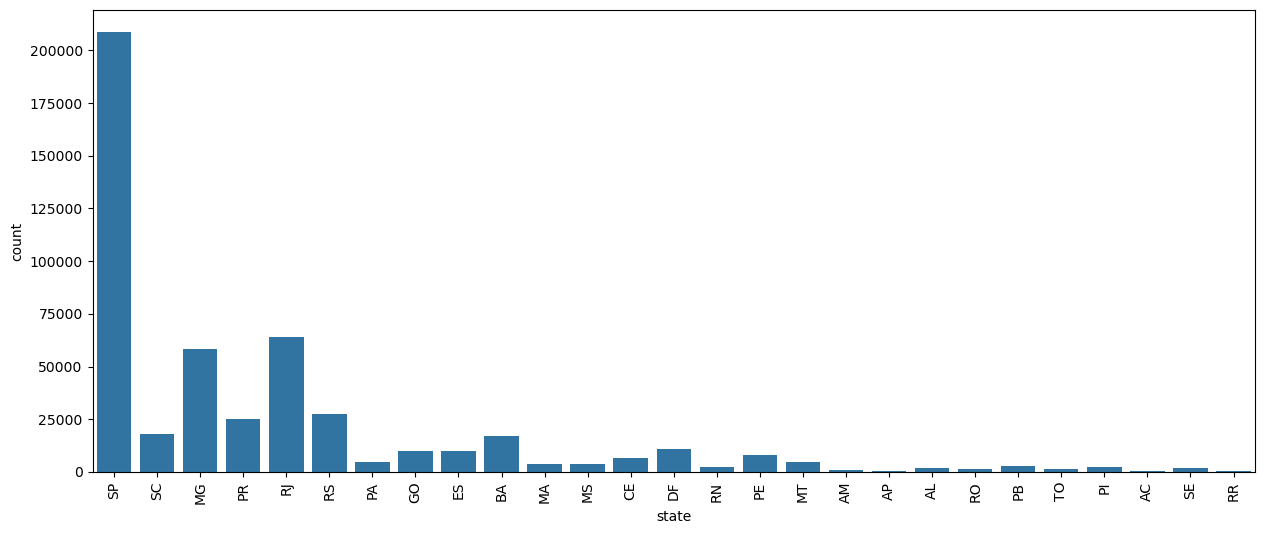

In [124]:
plt.figure(figsize=[15,6])
sns.barplot(x=df['state'],y=df['count'])
plt.xticks(rotation = 90)
plt.show()

In [125]:
#6. Calculate the number of orders per month in 2018.
query = """
select monthname(order_purchase_timestamp) as months,
count(order_id) as order_count
from orders 
where year(order_purchase_timestamp) = 2018
group by months
""" 

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()

data
df=pd.DataFrame(data,columns=('Months','Count'))

#setting order
o=['January','February','March','April','May','June','July','August','September','October']
df

,Months,Count
0,July,31460
1,August,32560
2,February,33640
3,June,30835
4,March,36055
5,January,36345
6,May,34365
7,April,34695
8,September,80
9,October,20


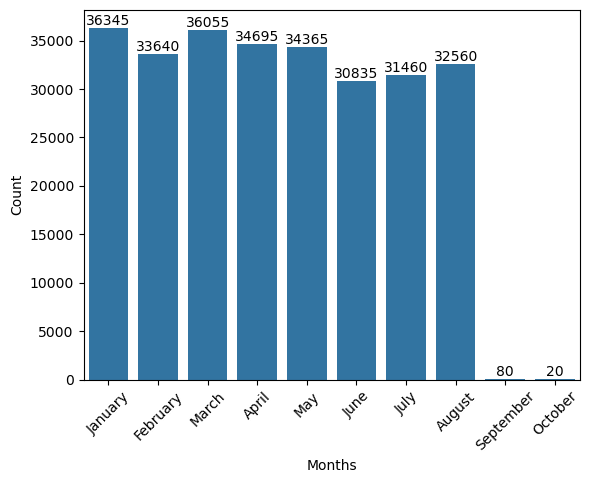

In [126]:
ax=sns.barplot(x='Months',y='Count',data=df,order=o)
plt.xticks(rotation=45)

ax.bar_label(ax.containers[0])
plt.show()

In [128]:
#7. Find the average number of products per order, grouped by customer city.
query = """
with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oi
from orders
join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oi),2) as average_order
from customers
join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city 
order by average_order"""

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()

data
df=pd.DataFrame(data,columns=['city','avg_orders'])
df

,city,avg_orders
0,brasopolis,15.00
1,campestre do maranhao,15.00
2,coreau,15.00
3,alto sao joao,15.00
4,campo alegre de minas,15.00
...,...,...
4105,matias olimpio,75.00
4106,candido godoi,90.00
4107,datas,90.00
4108,celso ramos,97.50


In [130]:
#8. Calculate the percentage of total revenue contributed by each product category
query = """
select
products.product_category category,  #we have already calculated sales per product (3)
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products 
join order_items
on products.product_id=order_items.product_id  
join payments
on payments.order_id = order_items.order_id
group by category
order by sales desc;
""" 

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()

df=pd.DataFrame(data,columns=['product','sales%'])
df

,product,sales%
0,bed table bath,96.33
1,HEALTH BEAUTY,93.22
2,computer accessories,89.15
3,Furniture Decoration,80.54
4,Watches present,80.39
...,...,...
69,PC Gamer,0.12
70,House Comfort 2,0.10
71,cds music dvds,0.07
72,Fashion Children's Clothing,0.04


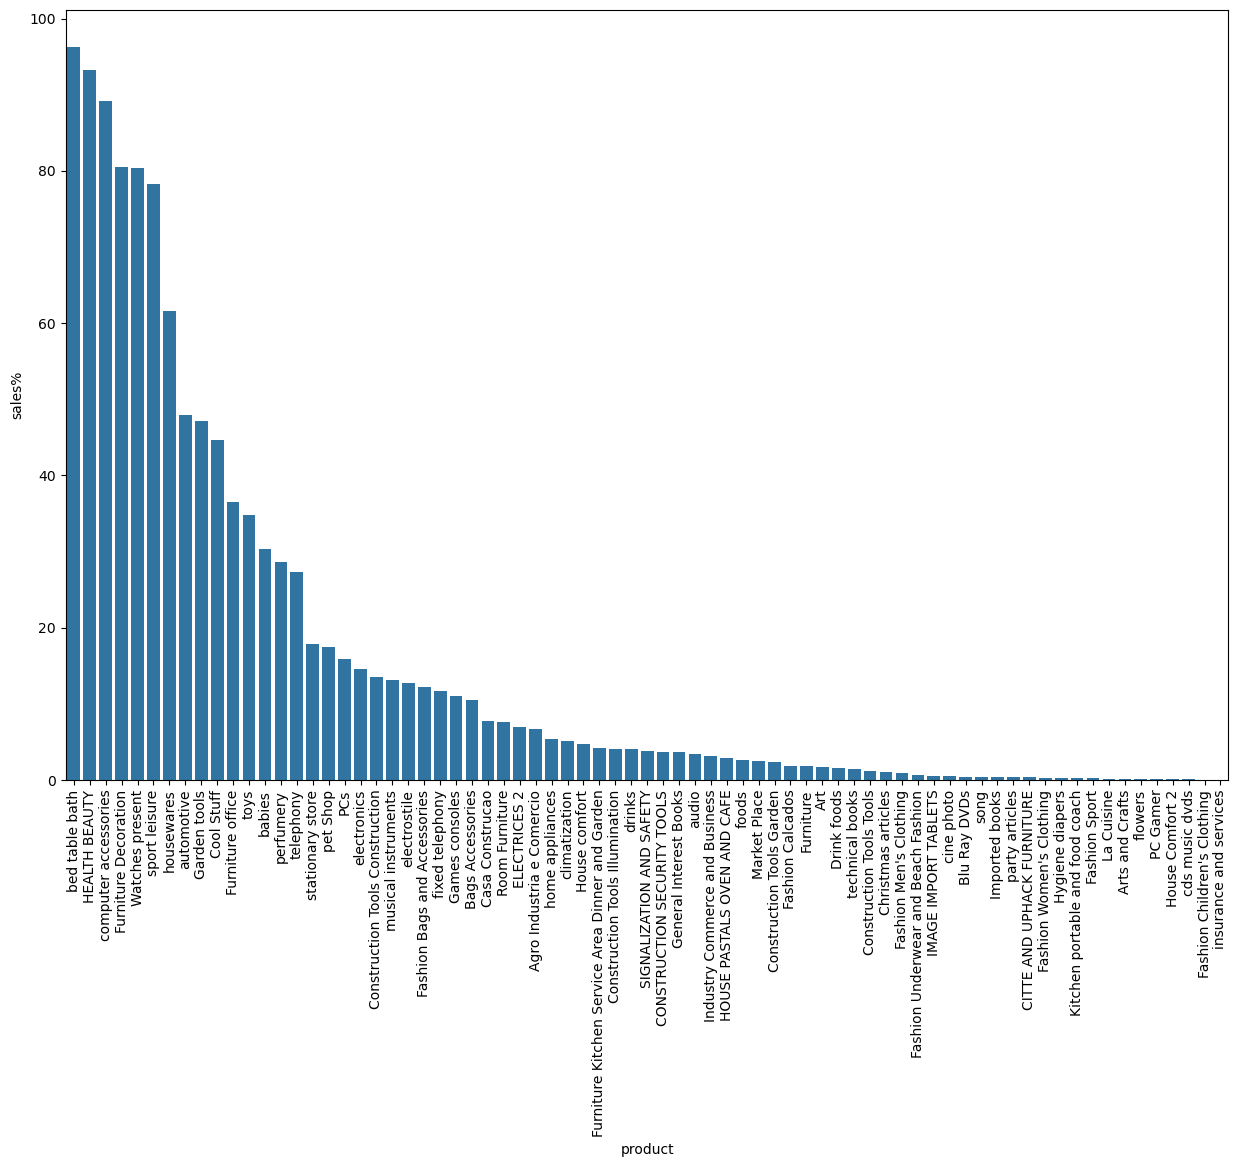

In [142]:
plt.figure(figsize=(15,10),)
sns.barplot(x=df['product'],y=df['sales%'])
plt.xticks(rotation=90)
plt.show()

In [143]:
# 9. Identify the correlation between product price and the number of times a product has been purchased.
query = """
select products.product_category as products,
count(order_items.product_id) as count,
round(avg(order_items.price),2) as avg_price
from products
join order_items
on products.product_id=order_items.product_id
group by products.product_category
""" 

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()
df=pd.DataFrame(data,columns=['product','count','avg price'])
df

,product,count,avg price
0,HEALTH BEAUTY,87096,130.13
1,sport leisure,77796,114.38
2,Cool Stuff,34377,169.90
3,computer accessories,70470,116.51
4,Watches present,53967,201.07
...,...,...,...
69,Kitchen portable and food coach,135,264.57
70,House Comfort 2,270,25.34
71,CITTE AND UPHACK FURNITURE,342,114.95
72,insurance and services,18,141.64


In [146]:
c=df['count']
p=df['avg price']

np.corrcoef(c,p)

array([[ 1.        , -0.10608567],
       [-0.10608567,  1.        ]])

In [147]:
#hence, ignoring diagonal value¶
#we can see the values are very closes to 0, therefore there is no relation between them

In [148]:
#10. Calculate the total revenue generated by each seller, and rank them by revenue

query = """
select *,dense_rank()over(order by revenue desc) as rn
from
(select
order_items.seller_id,round(sum(payments.payment_value),2) as revenue
from order_items
join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id)as a"""

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()
df=pd.DataFrame(data,columns=['Seller id','revenue','rank'])
df

,Seller id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,4564502.17,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,2773998.36,2
2,4a3ca9315b744ce9f8e9374361493884,2711207.43,3
3,1f50f920176fa81dab994f9023523100,2612280.78,4
4,53243585a1d6dc2643021fd1853d8905,2564127.72,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,172.89,3076
3091,702835e4b785b67a084280efca355756,167.04,3077
3092,4965a7002cca77301c82d3f91b82e1a9,147.24,3078
3093,77128dec4bec4878c37ab7d6169d6f26,136.98,3079


In [149]:
#11. Calculate the moving average of order values for each customer over their order history.

query = """
select 
	customer_id,
	order_purchase_timestamp,
	payment,
	avg(payment) over (
		partition by customer_id 
        order by order_purchase_timestamp
        rows between 2 preceding and current row) as moving_average
from 
	(select orders.customer_id,orders.order_purchase_timestamp,
	payments.payment_value as payment
	from payments join orders
	on payments.order_id = orders.order_id) as a;
"""

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()
df=pd.DataFrame(data)
df
#payments = MA since Each customer has only 1 row

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
1558285,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1558286,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1558287,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1558288,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


In [150]:
# 12. Calculate the cumulative sales per month for each year.

In [151]:
query = """
select years,months, payments,
round(sum(payments) over (order by years, months),2) as cumulative_Sales
from
(select
	year(orders.order_purchase_timestamp) as years,
    month(orders.order_purchase_timestamp) as months,
    round(sum(payments.payment_value),2) as payments
from orders
    join payments
    on orders.order_id = payments.order_id
    group by years ,months order by years , months) as a;"""

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()
pd.options.display.float_format = '{:,.2f}'.format   #Convert the Scientific Notation to Float:

df= pd.DataFrame(data,columns=['year','months','payment','cumulative_sales'])

df

,year,months,payment,cumulative_sales
0,2016,9,"3,783.60","3,783.60"
1,2016,10,"886,357.20","890,140.80"
2,2016,12,294.30,"890,435.10"
3,2017,1,"2,077,320.60","2,967,755.70"
4,2017,2,"4,378,620.14","7,346,375.84"
5,2017,3,"6,747,953.99","14,094,329.83"
6,2017,4,"6,266,820.44","20,361,150.27"
7,2017,5,"8,893,782.30","29,254,932.57"
8,2017,6,"7,669,145.70","36,924,078.27"
9,2017,7,"8,885,743.79","45,809,822.06"


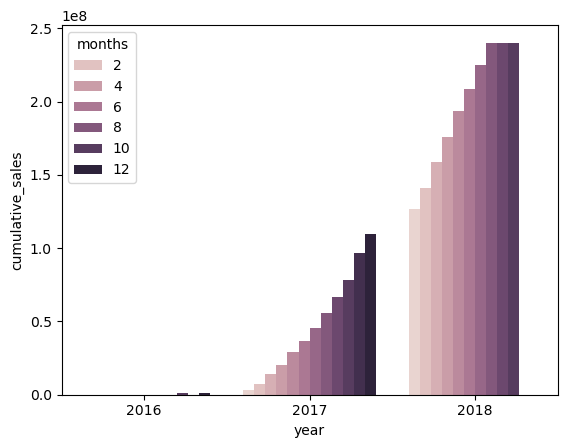

In [152]:
sns.barplot(x='year',y='cumulative_sales',hue='months',data=df)
plt.show()

In [153]:
# 13. Calculate the year-over-year growth rate of total sales.

In [165]:
query = """
select years, payments,
lag(payments,1) over (order by years) as previous_payments,
round(((payments - (lag(payments,1) over (order by years))) /
lag(payments,1) over (order by years)) *100,2) as year_growth
from
(select
	year(orders.order_purchase_timestamp) as years,
    round(sum(payments.payment_value),2) as payments
from orders
    join payments
    on orders.order_id = payments.order_id
    group by years order by years) as a;"""

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()
data 
pd.options.display.float_format = '{:,.2f}'.format

df = pd.DataFrame(data,columns=['year','sales','previous_year','yoy_growth%'])
df

,year,sales,previous_year,yoy_growth%
0,2016,"890,435.10",NaN,NaN
1,2017,"108,746,200.92","890,435.10","12,112.70"
2,2018,"130,496,445.78","108,746,200.92",20.00


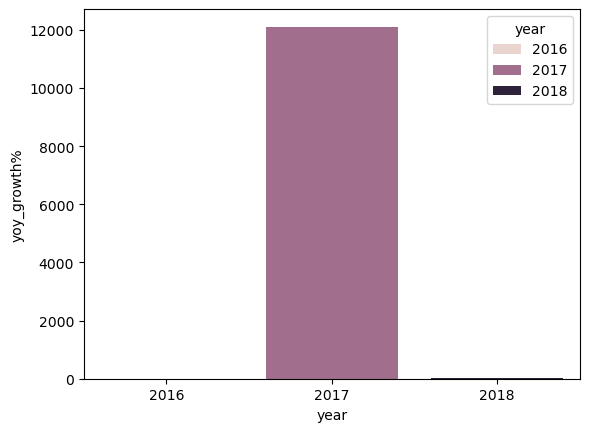

In [163]:
sns.barplot(x='year',y='yoy_growth%',hue='year',data=df)
plt.show()

In [ ]:
# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [166]:
query = """
with a as (select
        customers.customer_id,
        min(orders.order_purchase_timestamp) as first_order
    from customers
    join orders
    on customers.customer_id = orders.customer_id
    group by customers.customer_id
),
b as ( select
        a.customer_id,
        count(distinct orders.order_purchase_timestamp) as next_order
    from a
    join orders
    on orders.customer_id = a.customer_id
    and orders.order_purchase_timestamp > a.first_order
    and orders.order_purchase_timestamp < date_add(a.first_order, interval 6 month)
    group by a.customer_id
)
select
    100 * (COUNT(distinct b.customer_id) / COUNT(distinct a.customer_id)) as percentage
FROM a
LEFT JOIN b
ON a.customer_id = b.customer_id;"""

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()
df= pd.DataFrame(data,columns=['retention rate'])
df

,retention rate
0,0.0000


In [157]:
#15. Identify the top 3 customers who spent the most money in each year.

In [158]:
query = """
select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3;"""

cursor.execute(query)

# Fetch the result
data = cursor.fetchall()
df= pd.DataFrame(data,columns = ['year','id','payment','rank'])
df

,year,id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,"21,353.25",1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,"21,011.10",2
2,2016,4a06381959b6670756de02e07b83815f,"18,416.70",3
3,2017,1617b1357756262bfa56ab541c47bc16,"204,961.20",1
4,2017,c6e2731c5b391845f6800c97401a43a9,"103,939.65",2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,"100,899.90",3
6,2018,ec5b2ba62e574342386871631fafd3fc,"109,123.20",1
7,2018,f48d464a0baaea338cb25f816991ab1f,"103,833.15",2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,"72,141.60",3


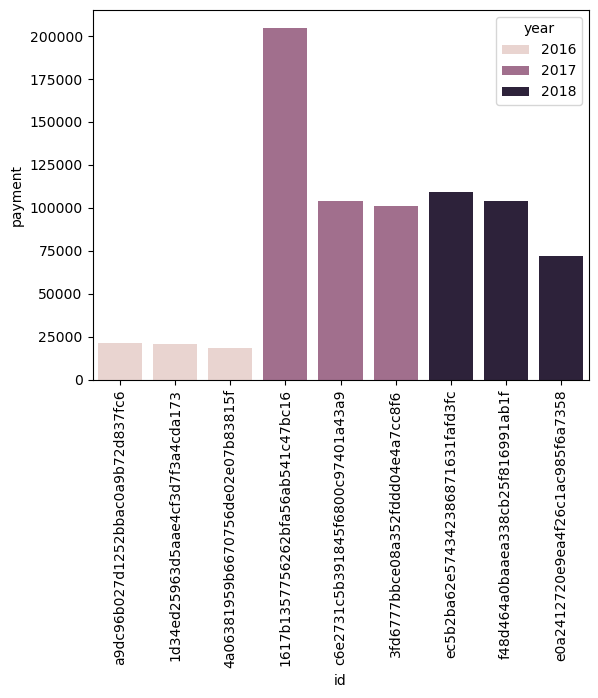

In [159]:
sns.barplot(x='id',y='payment',hue='year',data=df)
plt.xticks(rotation = 90)
plt.show()